# Homework 3: optimization of a CNN model
The task of this homework is to optimize a CNN model for the CIFAR-100. You are free to define the architecture of the model, and the training procedure. The only contraints are:
- It must be a `torch.nn.Module` object
- The number of trained parameters must be less than 1 million
- The test dataset must not be used for any step of training.
- The final training notebook should run on Google Colab within a maximum 1 hour approximately.
- Do not modify the random seed, as they are needed for reproducibility purpose.

For the grading, you must use the `evaluate` function defined below. It takes a model as input, and returns the test accuracy as output.

As a guideline, you are expected to **discuss** and motivate your choices regarding:
- Model architecture
- Hyperparameters (learning rate, batch size, etc)
- Regularization methods
- Optimizer
- Validation scheme

A code without any explanation of the choices will not be accepted. Test accuracy is not the only measure of success for this homework.

Remember that most of the train process is randomized, store your model's weights after training and load it before the evaluation!

In [1]:
import time
t0 = time.time()

## Example

### Loading packages and libraries

In [2]:
import random
import numpy as np
import torch
import torchvision


# Fix all random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# For full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# load the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

Using device: cuda


100%|██████████| 169M/169M [00:03<00:00, 46.6MB/s]


In [3]:
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

def evaluate(model):
    params_count = sum(p.numel() for p in model.parameters())
    print('The model has {} parameters'.format(params_count))

    if params_count > int(1e6):
        print('The model has too many parameters! Not allowed to evaluate.')
        return

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # print in bold red in a notebook
    print('\033[1m\033[91mAccuracy on the test set: {}%\033[0m'.format(100 * correct / total))


### Example of a simple CNN model

In [4]:
class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(8*8*64, 128)
        self.fc2 = torch.nn.Linear(128, 100)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 8*8*64)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Model parameters: ", sum(p.numel() for p in TinyNet().parameters()))

Model parameters:  556708


### Example of basic training

In [5]:

model = TinyNet()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))


Epoch [1/10], Loss: 4.6138
Epoch [2/10], Loss: 4.5809
Epoch [3/10], Loss: 4.5756
Epoch [4/10], Loss: 4.5898
Epoch [5/10], Loss: 4.5962
Epoch [6/10], Loss: 4.5979
Epoch [7/10], Loss: 4.6147
Epoch [8/10], Loss: 4.5324
Epoch [9/10], Loss: 4.5006
Epoch [10/10], Loss: 4.3964


In [6]:
# save the model on a file
torch.save(model.state_dict(), 'tiny_net.pt')

loaded_model = TinyNet()
loaded_model.load_state_dict(torch.load('tiny_net.pt', weights_only=True))
evaluate(loaded_model)

The model has 556708 parameters
Accuracy on the test set: 3.36%


### Solution Overview
- Goal: CIFAR-100 classifier under 1M params, trainable end-to-end on Colab in less than an hour, with transparent choices for architecture, training and validation.
- Strategy: lightweight residual CNN using depthwise-separable blocks to maximize capacity per parameter; AMP for speed; cosine LR for smooth decay. strong but standard regularization (data aug + label smoothing + weight decay + grad clipping).
- Reproducibility: fixed seeds across random/NumPy/torch, deterministic cuDNN, and a fixed random split for validation; test set used only via the provided evaluate.


In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler # Corrected from GradScalerQ
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

In [8]:
# Data
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25)
])

val_tf = transforms.Compose([
    transforms.ToTensor()
])


full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_tf)
val_size = 5000
train_size = len(full_train) - val_size
train_set, val_indices = random_split(full_train, [train_size, val_size])
# Rebuild val subset with val transforms
val_set = Subset(torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=val_tf),
                 val_indices.indices)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# Model (depthwise-separable residual blocks)
class DWBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        mid = out_ch // 2
        self.reduce = nn.Conv2d(in_ch, mid, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid)
        self.dw = nn.Conv2d(mid, mid, 3, stride=stride, padding=1, groups=mid, bias=False)
        self.bn2 = nn.BatchNorm2d(mid)
        self.expand = nn.Conv2d(mid, out_ch, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False) if (in_ch != out_ch or stride != 1) else None

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.reduce(x)))
        out = F.relu(self.bn2(self.dw(out)))
        out = self.bn3(self.expand(out))
        if self.skip is not None:
            identity = self.skip(identity)
        return F.relu(out + identity)

class SmallNet(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(1,3,1,1)
        std = torch.tensor([0.2675, 0.2565, 0.2761]).view(1,3,1,1)
        self.register_buffer('mean', mean)
        self.register_buffer('std', std)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 96, 3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True)
        )
        self.stage1 = nn.Sequential(DWBlock(96, 128), DWBlock(128, 128))
        self.stage2 = nn.Sequential(DWBlock(128, 192, stride=2), DWBlock(192, 192))
        self.stage3 = nn.Sequential(DWBlock(192, 256, stride=2), DWBlock(256, 256))
        self.stage4 = nn.Sequential(DWBlock(256, 448, stride=2), DWBlock(448, 448))
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(448, num_classes)

    def forward(self, x):
          x = (x - self.mean) / self.std
          x = self.stem(x)
          x = self.stage1(x)
          x = self.stage2(x)
          x = self.stage3(x)
          x = self.stage4(x)
          x = self.pool(x).flatten(1)
          return self.fc(x)

model = SmallNet().to(device)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable params: 845380


### Data & Preprocessing
- Augmentations (train): random crop (padding=4) + horizontal flip + random erasing p=0.25. Rationale: classic CIFAR-100 augmentations improve invariance, random erasing acts as occlusion regularization and reduces overfitting on 100-way fine-grained classes.
- Normalization: applied inside the model via registered mean/std buffers so train/val/test all see identical preprocessing regardless of the external transforms.
- Validation split: 5k held out from the training set via random_split with a fixed seed -> stable val metric across runs; ensures no test leakage. Val loader uses only ToTensor to match test-time preprocessing.

### Model Design (SmallNet, ~0.84M params)
- Blocks: depthwise-separable convs with residual skips (DWBlock) to cut params/FLOPs while keeping gradient flow stable.
- Channel schedule: 96->128->192->256->448 across stages; chosen to stay comfortably under 1M params yet give increasing capacity at deeper stages.
- Stem + stages + global avg pool + linear head; residual projections used when shape/stride changes.
- In-model normalization: (x - mean) / std at the start of forward keeps preprocessing consistent with the provided evaluate loader (which uses raw ToTensor).


In [9]:
# Train/val loop
epochs = 50
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
scaler = GradScaler('cuda')
best_val = 0.0
best_path = 'best_smallnet.pth'

# Track metrics for plotting
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

for epoch in range(epochs):
    model.train()
    tot_loss = tot_correct = tot_seen = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast('cuda'):
          logits = model(imgs)
          loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        tot_loss += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_seen += labels.size(0)

    scheduler.step()
    train_loss = tot_loss / tot_seen
    train_acc = tot_correct / tot_seen

    model.eval()
    val_loss_tot = val_correct = val_seen = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            val_logits = model(imgs)
            vloss = criterion(val_logits, labels)
            val_loss_tot += vloss.item() * labels.size(0)
            val_correct += (val_logits.argmax(1) == labels).sum().item()
            val_seen += labels.size(0)
    val_acc = val_correct / val_seen
    val_loss = val_loss_tot / val_seen

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(f"Epoch {epoch+1}/{epochs} - train_loss {train_loss:.4f} - train_acc {train_acc:.4f} - val_loss {val_loss:.4f} - val_acc {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), best_path)

print("Best val_acc:", best_val)


Epoch 1/50 - train_loss 4.1262 - train_acc 0.0838 - val_loss 3.7706 - val_acc 0.1578
Epoch 2/50 - train_loss 3.4942 - train_acc 0.2039 - val_loss 3.4389 - val_acc 0.2264
Epoch 3/50 - train_loss 3.1045 - train_acc 0.2945 - val_loss 3.3055 - val_acc 0.2660
Epoch 4/50 - train_loss 2.8715 - train_acc 0.3593 - val_loss 2.8476 - val_acc 0.3620
Epoch 5/50 - train_loss 2.7240 - train_acc 0.3983 - val_loss 2.7343 - val_acc 0.4066
Epoch 6/50 - train_loss 2.6113 - train_acc 0.4320 - val_loss 2.6589 - val_acc 0.4196
Epoch 7/50 - train_loss 2.5299 - train_acc 0.4524 - val_loss 2.7640 - val_acc 0.4056
Epoch 8/50 - train_loss 2.4701 - train_acc 0.4710 - val_loss 2.5605 - val_acc 0.4532
Epoch 9/50 - train_loss 2.4201 - train_acc 0.4876 - val_loss 2.8896 - val_acc 0.3614
Epoch 10/50 - train_loss 2.3780 - train_acc 0.5015 - val_loss 2.6823 - val_acc 0.4330
Epoch 11/50 - train_loss 2.3344 - train_acc 0.5140 - val_loss 2.4786 - val_acc 0.4708
Epoch 12/50 - train_loss 2.3030 - train_acc 0.5208 - val_loss 2

### Training Setup
- Optimizer: SGD, momentum=0.9, weight_decay=5e-4 (standard CIFAR recipe; decouples noise scale from LR and controls overfitting).
- Learning rate & schedule: LR=0.1 with cosine annealing over 50 epochs for smooth decay without manual milestones.
- Loss: CrossEntropy with label_smoothing=0.1 to reduce overconfidence and improve calibration.
- Precision & stability: AMP (autocast, GradScaler) for faster mixed-precision training on GPU; grad clipping at 1.0 to prevent rare spikes from destabilizing updates.
- Batch sizes: 128 (train) / 256 (val) balance throughput and memory on Colab T4/V100; num_workers=2, pin_memory=True to keep the GPU fed.

### Validation & Checkpointing
- Metric: top-1 accuracy on the 5k val split every epoch; best checkpoint saved by highest val accuracy to avoid late-epoch regression.
- Test evaluation: after training, reload best checkpoint and run the provided evaluate to get test accuracy; respects the no-test-during-training rule.


### Training Curves
Three-panel view of accuracy, loss, and learning-rate schedule. Dashed line marks the epoch with best validation accuracy; the LR plot highlights the cosine schedule value at that point.

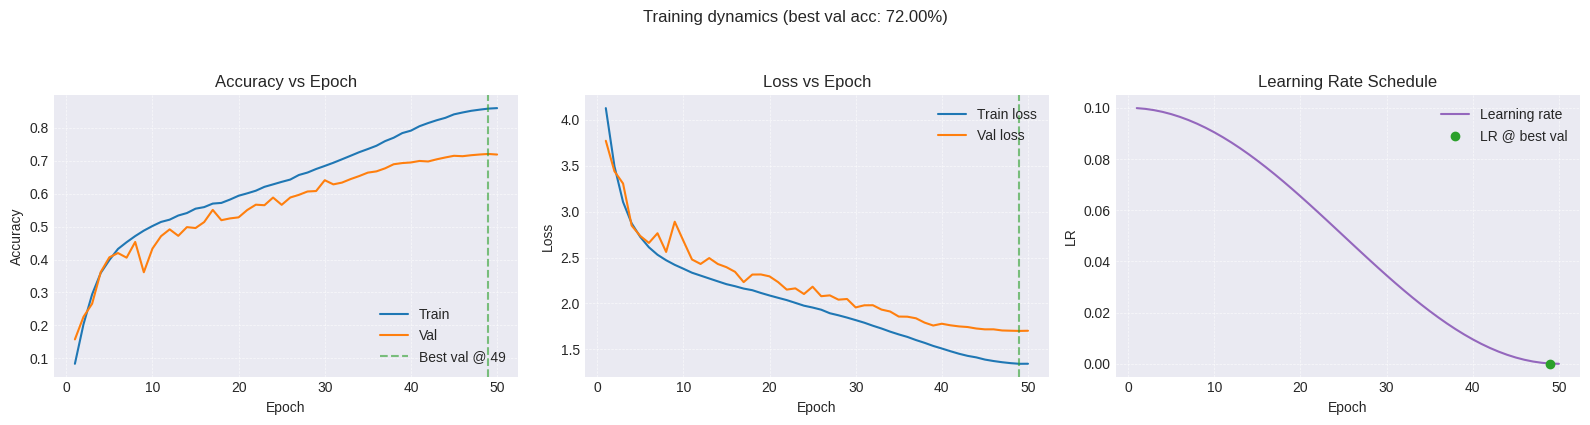

In [10]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
epochs = range(1, len(history["train_loss"]) + 1)
best_epoch = max(range(len(history["val_acc"])), key=lambda i: history["val_acc"][i]) + 1
best_val = history["val_acc"][best_epoch - 1] * 100

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(epochs, history["train_acc"], label="Train", color="tab:blue")
axes[0].plot(epochs, history["val_acc"], label="Val", color="tab:orange")
axes[0].axvline(best_epoch, color="tab:green", linestyle="--", alpha=0.6, label=f"Best val @ {best_epoch}")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy vs Epoch")
axes[0].legend(loc="lower right")

axes[1].plot(epochs, history["train_loss"], label="Train loss", color="tab:blue")
axes[1].plot(epochs, history["val_loss"], label="Val loss", color="tab:orange")
axes[1].axvline(best_epoch, color="tab:green", linestyle="--", alpha=0.6)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss vs Epoch")
axes[1].legend(loc="upper right")

axes[2].plot(epochs, history["lr"], label="Learning rate", color="tab:purple")
axes[2].scatter(best_epoch, history["lr"][best_epoch - 1], color="tab:green", zorder=5, label="LR @ best val")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("LR")
axes[2].set_title("Learning Rate Schedule")
axes[2].legend()

for ax in axes:
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

fig.suptitle(f"Training dynamics (best val acc: {best_val:.2f}%)", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
# Load best and run provided evaluate() on the test set
model.load_state_dict(torch.load(best_path, map_location=device))
model.to(device)
evaluate(model)

The model has 845380 parameters
Accuracy on the test set: 72.06%


### Results & Constraints
- Params: ~0.84M (<1M limit).
- Val accuracy (best): 0.72.
- Test accuracy (from evaluate): 72.06%.
- Wall time: ~20 min minutes (using CUDA) end-to-end on Colab; completed within the ~1-hour requirement.

In [12]:
t1 = time.time()
elapsed = t1 - t0
print(f"Total wall time: {elapsed/60:.1f} min")
if elapsed < 3600:
    print("✅ End-to-end run completed in under 1 hour.")
else:
    print("⚠️ Took longer than 1 hour.")


Total wall time: 19.0 min
✅ End-to-end run completed in under 1 hour.
